In [2]:
! pip show deepctr
! pip show tensorflow

Name: deepctr
Version: 0.9.3
Summary: Easy-to-use,Modular and Extendible package of deep learning based CTR(Click Through Rate) prediction models with tensorflow 1.x and 2.x .
Home-page: https://github.com/shenweichen/deepctr
Author: Weichen Shen
Author-email: weichenswc@163.com
License: Apache-2.0
Location: /opt/anaconda3/envs/datagrand/lib/python3.11/site-packages
Requires: h5py, requests
Required-by: 
Name: tensorflow
Version: 2.16.2
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /opt/anaconda3/envs/datagrand/lib/python3.11/site-packages
Requires: absl-py, astunparse, flatbuffers, gast, google-pasta, grpcio, h5py, keras, libclang, ml-dtypes, numpy, opt-einsum, packaging, protobuf, requests, setuptools, six, tensorboard, tensorflow-io-gcs-filesystem, termcolor, typing-extensions, wrapt
Required-by: 


In [16]:
def get_feature_columns():
    """构建特征列"""
    # 稀疏特征
    sparse_features = [
        SparseFeat('user_id', vocabulary_size=100, embedding_dim=8),
        SparseFeat('gender', vocabulary_size=2, embedding_dim=4),
        SparseFeat('region', vocabulary_size=5, embedding_dim=4),
        SparseFeat('user_hot', vocabulary_size=3, embedding_dim=4),
        SparseFeat('video_id', vocabulary_size=100, embedding_dim=8),
        SparseFeat('video_type', vocabulary_size=5, embedding_dim=4),
        SparseFeat('video_quality', vocabulary_size=2, embedding_dim=4)
    ]
    
    # 稠密特征
    dense_features = [
        DenseFeat('age', 1),
        DenseFeat('video_length', 1)
    ]
    
    # 序列特征
    seq_features = [
        VarLenSparseFeat(
            SparseFeat('hist_video_id', vocabulary_size=100, embedding_dim=8, embedding_name='video_id'),
            maxlen=50,
            length_name="seq_length"
        ),
        VarLenSparseFeat(
            SparseFeat('hist_video_type', vocabulary_size=5, embedding_dim=4, embedding_name='video_type'),
            maxlen=50,
            length_name="seq_length"
        )
    ]
    
    return sparse_features, dense_features, seq_features

In [17]:
import tensorflow as tf
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.layers import Dense, Flatten,Lambda

from deepctr.layers.utils import combined_dnn_input
from deepctr.layers.sequence import AttentionSequencePoolingLayer
from deepctr.feature_column import SparseFeat, DenseFeat, VarLenSparseFeat
from deepctr.inputs import embedding_lookup 
from deepctr.feature_column import build_input_features,input_from_feature_columns

from deepctr.layers.core import DNN
from deepctr.layers.core import PredictionLayer
from deepctr.inputs import create_embedding_matrix,get_dense_input,varlen_embedding_lookup,get_varlen_pooling_list
from deepctr.layers.utils import concat_func,reduce_sum

In [18]:
def DIN_MMOE_2(
    dnn_feature_columns,
    history_feature_list,
    num_experts=4,
    expert_dnn_hidden_units=(256, 128),
    tower_dnn_hidden_units=(64,),
    gate_dnn_hidden_units=(),
    l2_reg_embedding=1e-6,
    l2_reg_dnn=0,
    seed=1024,
    dnn_dropout=0,
    dnn_activation='relu',
    dnn_use_bn=False,
    num_tasks =4,
    task_types=('binary', 'regression', 'binary', 'binary'),
    task_names=('is_exceed_5s', 'stay_time', 'is_watch', 'is_buy')
):
    """
    DIN和MMOE结合的多任务学习模型
    
    参数:
        dnn_feature_columns: 特征列配置
        history_feature_list: 历史行为特征列表
        num_experts: 专家网络数量
        expert_dnn_hidden_units: 专家网络隐藏层配置
        tower_dnn_hidden_units: 任务塔网络配置
        gate_dnn_hidden_units: 门控网络配置
        ...
    """
    
    # 构建输入层
    features = build_input_features(dnn_feature_columns)
    
    sparse_feature_columns = list(
        filter(lambda x: isinstance(x, SparseFeat), dnn_feature_columns)) if dnn_feature_columns else []
    dense_feature_columns = list(
        filter(lambda x: isinstance(x, DenseFeat), dnn_feature_columns)) if dnn_feature_columns else []
    varlen_sparse_feature_columns = list(
        filter(lambda x: isinstance(x, VarLenSparseFeat), dnn_feature_columns)) if dnn_feature_columns else []
    
    history_feature_columns = []
    sparse_varlen_feature_columns = []
    history_fc_names = list(map(lambda x: "hist_" + x, history_feature_list))
    for fc in varlen_sparse_feature_columns:
        feature_name = fc.name
        if feature_name in history_fc_names:
            history_feature_columns.append(fc)
        else:
            sparse_varlen_feature_columns.append(fc)

    inputs_list = list(features.values())

    embedding_dict = create_embedding_matrix(dnn_feature_columns, l2_reg_embedding, seed, prefix="")

    query_emb_list = embedding_lookup(embedding_dict, features, sparse_feature_columns, history_feature_list,
                                        history_feature_list, to_list=True)
    keys_emb_list = embedding_lookup(embedding_dict, features, history_feature_columns, history_fc_names,
                                        history_fc_names, to_list=True)
    dnn_input_emb_list = embedding_lookup(embedding_dict, features, sparse_feature_columns,
                                            mask_feat_list=history_feature_list, to_list=True)
    dense_value_list = get_dense_input(features, dense_feature_columns)

    sequence_embed_dict = varlen_embedding_lookup(embedding_dict, features, sparse_varlen_feature_columns)
    sequence_embed_list = get_varlen_pooling_list(sequence_embed_dict, features, sparse_varlen_feature_columns,
                                                    to_list=True)

    dnn_input_emb_list += sequence_embed_list

    keys_emb = concat_func(keys_emb_list, mask=True)
    deep_input_emb = concat_func(dnn_input_emb_list)
    query_emb = concat_func(query_emb_list, mask=True)
    hist = AttentionSequencePoolingLayer(supports_masking=True)([
        query_emb, keys_emb])
    
    
    deep_input_emb = concat_func([deep_input_emb, hist])
    deep_input_emb = Flatten()(deep_input_emb)
    din_output = combined_dnn_input([deep_input_emb], dense_value_list)
    
    
    # build expert layer
    expert_outs = []
    for i in range(num_experts):
        expert_network = DNN(expert_dnn_hidden_units, dnn_activation, l2_reg_dnn, dnn_dropout, dnn_use_bn, seed=seed,
                             name='expert_' + str(i))(din_output)
        expert_outs.append(expert_network)

    expert_concat = Lambda(lambda x: tf.stack(x, axis=1))(expert_outs)  # None,num_experts,dim

    mmoe_outs = []
    for i in range(num_tasks):  # one mmoe layer: nums_tasks = num_gates
        # build gate layers
        gate_input = DNN(gate_dnn_hidden_units, dnn_activation, l2_reg_dnn, dnn_dropout, dnn_use_bn, seed=seed,
                         name='gate_' + task_names[i])(din_output)
        gate_out = Dense(num_experts, use_bias=False, activation='softmax',
                         name='gate_softmax_' + task_names[i])(gate_input)
        gate_out = Lambda(lambda x: tf.expand_dims(x, axis=-1))(gate_out)

        # gate multiply the expert
        gate_mul_expert = Lambda(lambda x: reduce_sum(x[0] * x[1], axis=1, keep_dims=False),
                                 name='gate_mul_expert_' + task_names[i])([expert_concat, gate_out])
        mmoe_outs.append(gate_mul_expert)

    task_outs = []
    for task_type, task_name, mmoe_out in zip(task_types, task_names, mmoe_outs):
        # build tower layer
        tower_output = DNN(tower_dnn_hidden_units, dnn_activation, l2_reg_dnn, dnn_dropout, dnn_use_bn, seed=seed,
                           name='tower_' + task_name)(mmoe_out)

        logit = Dense(1, use_bias=False)(tower_output)
        output = PredictionLayer(task_type, name=task_name)(logit)
        task_outs.append(output)

    model = Model(inputs=inputs_list, outputs=task_outs)
    return model

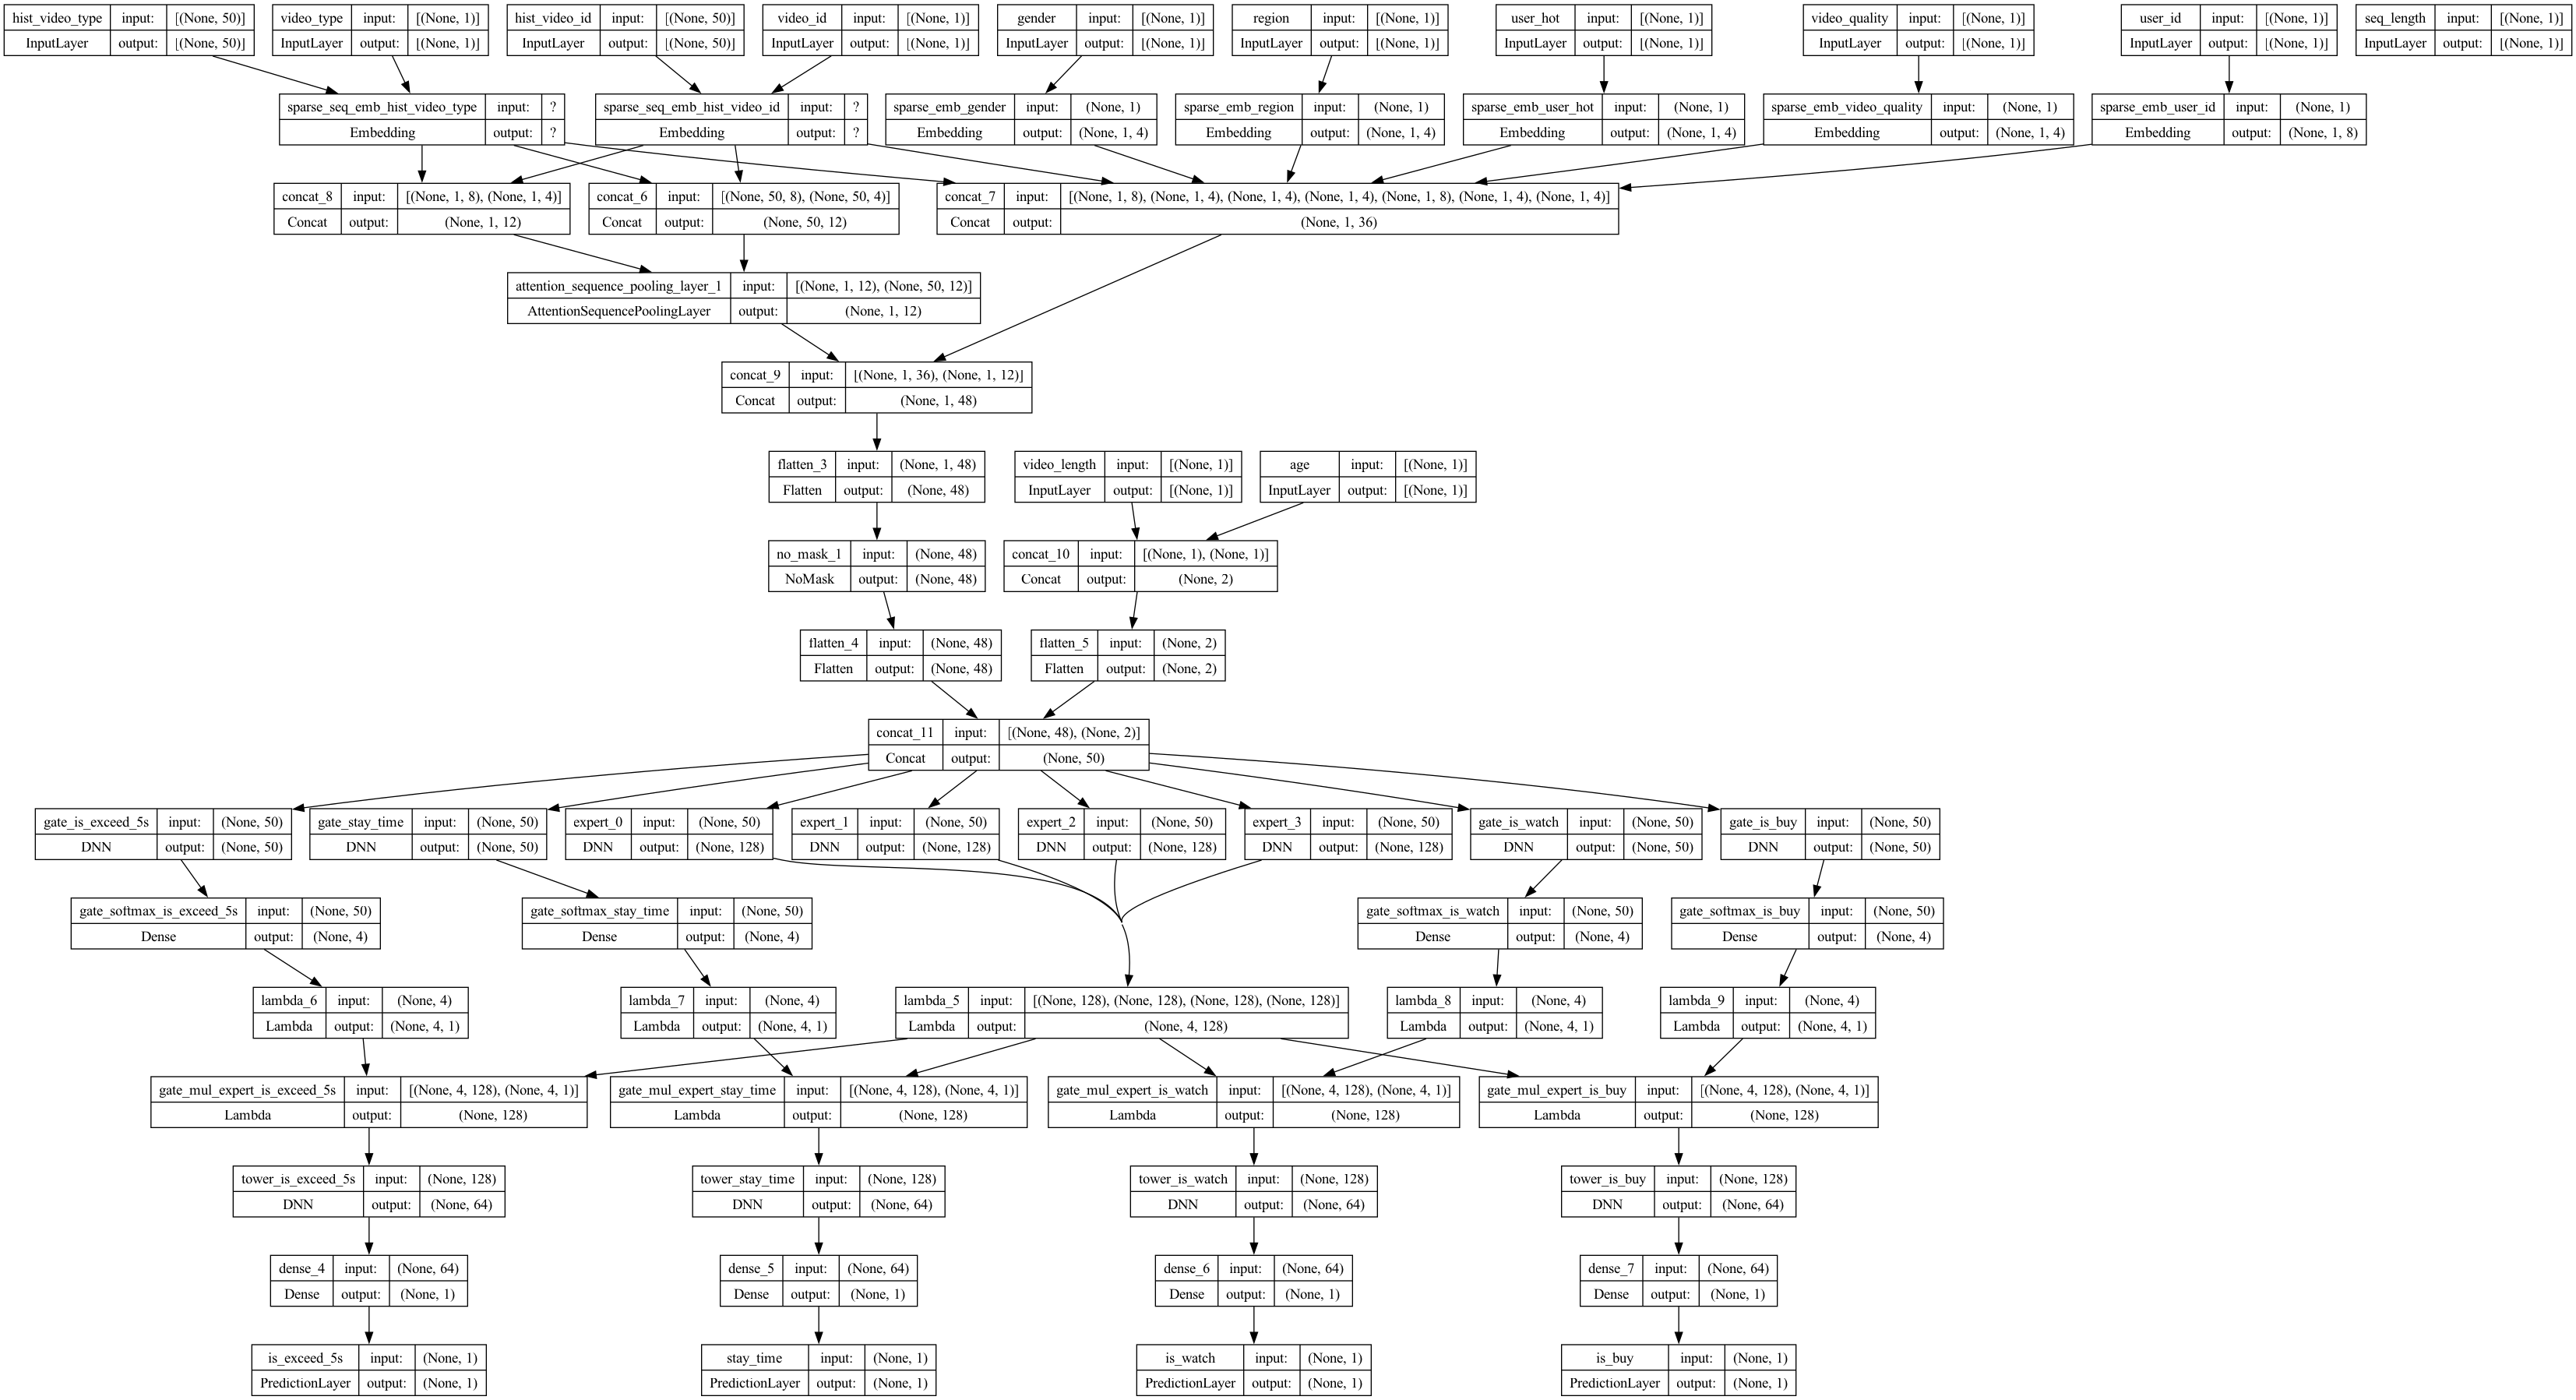

In [19]:
## 查看模型结构
from tensorflow import keras

sparse_features, dense_features, seq_features = get_feature_columns()
dnn_feature_columns = sparse_features + dense_features + seq_features
history_feature_list = ['video_id', 'video_type']

model = DIN_MMOE_2(
    dnn_feature_columns,
    history_feature_list,
    num_experts=4,
    expert_dnn_hidden_units=(256, 128),
    tower_dnn_hidden_units=(64,),
    task_types=('binary', 'regression', 'binary', 'binary'),
    task_names=('is_exceed_5s', 'stay_time', 'is_watch', 'is_buy')
)
keras.utils.plot_model(model, to_file="DIN_MMOE.png", show_shapes=True)

In [47]:
def train_model(train_model_input,train):
    # 获取特征列配置
    sparse_features, dense_features, seq_features = get_feature_columns()
    dnn_feature_columns = sparse_features + dense_features + seq_features
    history_feature_list = ['video_id', 'video_type']
    

    # 构建模型
    model = DIN_MMOE_2(
        dnn_feature_columns,
        history_feature_list,
        num_experts=4,
        expert_dnn_hidden_units=(256, 128),
        tower_dnn_hidden_units=(64,),
        task_types=('binary', 'regression', 'binary', 'binary'),
        task_names=('is_exceed_5s', 'stay_time', 'is_watch', 'is_buy')
    )
    
    # 编译模型
    model.compile(
        optimizer="adam",
        loss={
            'is_exceed_5s': 'binary_crossentropy',
            'stay_time': 'mse',
            'is_watch': 'binary_crossentropy',
            'is_buy': 'binary_crossentropy'
        },
        loss_weights={
            'is_exceed_5s': 1.0,
            'stay_time': 1.0,
            'is_watch': 1.0,
            'is_buy': 1.0
        },
        metrics={
            'is_exceed_5s': ['AUC'],
            'stay_time': ['mse'],
            'is_watch': ['AUC'],
            'is_buy': ['AUC']
        }
    )
    
    # 训练模型
    history = model.fit(
        train_model_input,
        [train['is_exceed_5s'], train['stay_time'], 
         train['is_watch'], train['is_buy']],
        batch_size=256,
        epochs=10,
        validation_split=0.2
    )

In [77]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from deepctr.models import PLE
from deepctr.feature_column import SparseFeat, DenseFeat, get_feature_names

In [115]:
def preprocess_data(df):
    """
    完整的数据预处理函数
    """
    df = df.copy()
    
    # 1. 计算每个特征的词汇表大小
    vocab_sizes = {
        'user_id': 100,
        'gender': 2,
        'region': 5,
        'user_hot': 3,
        'video_id': 100,
        'video_type': 5,
        'video_quality': 2
    }
    
    # 2. 处理稀疏特征
    sparse_features = ['user_id', 'gender', 'region', 'user_hot', 
                      'video_id', 'video_type', 'video_quality']
    
    for feat in sparse_features:
        # 使用LabelEncoder，并确保值在范围内
        lbe = LabelEncoder()
        df[feat] = lbe.fit_transform(df[feat].astype(str))
        # 对值进行取模操作，确保在词汇表大小范围内
        df[feat] = df[feat] % vocab_sizes[feat]
        df[feat] = df[feat].astype('int32')
    
    # 3. 处理密集特征
    dense_features = ['age', 'video_length']
    mms = MinMaxScaler(feature_range=(0, 1))
    df[dense_features] = mms.fit_transform(df[dense_features])
    df[dense_features] = df[dense_features].astype('float32')
    
    # 4. 处理目标变量
    df['stay_time'] = mms.fit_transform(df[['stay_time']])
    df['is_exceed_5s'] = df['is_exceed_5s'].astype('int32')
    df['is_watch'] = df['is_watch'].astype('int32')
    df['is_buy'] = df['is_buy'].astype('int32')
    df['stay_time'] = df['stay_time'].astype('float32')
    
    # 5. 创建历史序列
    df['hist_video_id'] = create_hist_sequence(df, 'user_id', 'video_id', vocab_sizes['video_id'])
    df['hist_video_type'] = create_hist_sequence(df, 'user_id', 'video_type', vocab_sizes['video_type'])
    df['seq_length'] = df['hist_video_id'].apply(
        lambda x: len([i for i in x if i != 0])
    ).astype('int32')
    
    return df

def create_hist_sequence(df, user_col, target_col, vocab_size, max_len=50):
    """
    创建历史序列，确保值在词汇表大小范围内
    """
    hist_dict = {}
    for user_id in df[user_col].unique():
        # 获取用户历史记录并确保值在范围内
        user_records = df[df[user_col] == user_id][target_col].values % vocab_size
        hist_dict[user_id] = [list(user_records[max(0, i-max_len):i]) 
                             for i in range(1, len(user_records)+1)]
    
    hist_sequences = []
    for user_id in df[user_col]:
        user_hist = hist_dict[user_id].pop(0) if hist_dict[user_id] else []
        if len(user_hist) < max_len:
            user_hist = [0] * (max_len - len(user_hist)) + user_hist
        elif len(user_hist) > max_len:
            user_hist = user_hist[-max_len:]
        hist_sequences.append(user_hist)
    
    return hist_sequences

# 处理数据
df = pd.read_csv("../mulit_task_data.csv")
processed_data = preprocess_data(df)

# 划分训练集和测试集
split_index = int(len(processed_data) * 0.8)
train_data = processed_data[:split_index]
test_data = processed_data[split_index:]

# 准备模型输入
feature_names = get_feature_names(fixlen_feature_columns)
train_model_input = {name: train_data[name] for name in feature_names}

# 确保序列特征是numpy数组
train_model_input['hist_video_id'] = np.array(train_data['hist_video_id'].tolist(), dtype='int32')
train_model_input['hist_video_type'] = np.array(train_data['hist_video_type'].tolist(), dtype='int32')
train_model_input['seq_length'] = train_data['seq_length'].values

In [116]:
# 使用修改后的函数处理数据
df = pd.read_csv("../mulit_task_data.csv")
processed_data = preprocess_data(df)

# 划分训练集和测试集
split_index = int(len(processed_data) * 0.8)
train_data = processed_data[:split_index]
test_data = processed_data[split_index:]

# 获取特征列
sparse_features, dense_features, seq_features = get_feature_columns()
dnn_feature_columns = sparse_features + dense_features + seq_features

# 准备模型输入
train_model_input = prepare_model_input(train_data, dnn_feature_columns)

In [117]:
train_model(train_model_input,train_data)

Epoch 1/10
1/1 [==============================] - 2s 2s/step - loss: 2.5716 - is_exceed_5s_loss: 0.6976 - stay_time_loss: 0.4728 - is_watch_loss: 0.7121 - is_buy_loss: 0.6890 - is_exceed_5s_auc: 0.2605 - stay_time_mse: 0.4728 - is_watch_auc_1: 0.2933 - is_buy_auc_2: 0.6714 - val_loss: 2.5170 - val_is_exceed_5s_loss: 0.6935 - val_stay_time_loss: 0.4368 - val_is_watch_loss: 0.7064 - val_is_buy_loss: 0.6803 - val_is_exceed_5s_auc: 0.2214 - val_stay_time_mse: 0.4368 - val_is_watch_auc_1: 0.1036 - val_is_buy_auc_2: 0.8194
Epoch 2/10
1/1 [==============================] - 0s 29ms/step - loss: 2.4837 - is_exceed_5s_loss: 0.6919 - stay_time_loss: 0.4044 - is_watch_loss: 0.7035 - is_buy_loss: 0.6838 - is_exceed_5s_auc: 0.2240 - stay_time_mse: 0.4044 - is_watch_auc_1: 0.2751 - is_buy_auc_2: 0.7721 - val_loss: 2.4398 - val_is_exceed_5s_loss: 0.6881 - val_stay_time_loss: 0.3779 - val_is_watch_loss: 0.6978 - val_is_buy_loss: 0.6760 - val_is_exceed_5s_auc: 0.2179 - val_stay_time_mse: 0.3779 - val_is